<a href="https://colab.research.google.com/github/robinvloeberghs/Dynamax/blob/main/Hierarchical_Bernoulli_LDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Hierarchical) Bernoulli LDS Model

\begin{align*}
x_t &\sim \mathcal{N}(a x_{t-1}, \eta^2) \\
y_t &\sim \mathrm{Bern}(\sigma(w^\top u_t + x_t)) 
\end{align*}

where $x_t \in \mathbb{R}$ are the latent shift in the decision criterion, and $u_t = (1, \ldots)$ are a vector of covariates that always include a bias.

The parameters are $\theta = (a, \eta, w)$. We want to estimate them via maximum likelihood estimation. 

## Strategy

Use conditional moments Gaussian filter (CMGF) to estimate the posterior distribution $p(x_{1:T} \mid y_{1:T}, \theta)$, as well as the marginal likelihood $p(y_{1:T} \mid \theta)$. 

Then we can perform maximum likelihood estimation by gradient ascent on the marginal likelihood. 

In order to use CMGF we need the conditional moments of the emissions. Those are in closed form,

\begin{align*}
\mathbb{E}[y_t \mid x_t] &= \sigma(w^\top u_t + x_t) \\
\mathbb{V}[y_t \mid x_t] &= \sigma(w^\top u_t + x_t) (1 - \sigma(w^\top u_t + x_t))
\end{align*}


In [4]:
%%capture 
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    !pip install git+https://github.com/probml/dynamax.git#egg=dynamax
    import dynamax

In [5]:
%%capture 
try:
    import optax
except ModuleNotFoundError:
    print('installing optax')
    !pip install optax
    import optax

In [2]:
from functools import partial

from jax import vmap, grad, value_and_grad, lax
from jax import numpy as jnp
from jax import random as jr
from jax.nn import softplus, sigmoid
from matplotlib import pyplot as plt

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import optax

from dynamax.generalized_gaussian_ssm import ParamsGGSSM, GeneralizedGaussianSSM, EKFIntegrals
from dynamax.generalized_gaussian_ssm import conditional_moments_gaussian_smoother


ModuleNotFoundError: ignored

## First initialize a model and sample from it

In [ ]:
input_dim = 7
state_dim = 1
emission_dim = 1

# parameterize eta as diag(softplus(unc_eta))
true_params = dict(A=jnp.eye(state_dim),
                   unc_eta=jnp.zeros(state_dim),
                   w=jr.normal(jr.PRNGKey(1), (input_dim,)))

def initialize_params(key):
    # Randomly initialize parameters for fitting
    key1, key2, key3 = jr.split(key, 3)
    A = jnp.diag(tfd.Beta(10.0, 1.0).sample(seed=key1, sample_shape=(state_dim,)))
    unc_eta = tfd.Normal(0.0, 1.0).sample(seed=key2, sample_shape=(state_dim,))
    w = tfd.Normal(0.0, 1.0).sample(seed=key3, sample_shape=(input_dim,))
    return dict(A=A, unc_eta=unc_eta, w=w)


def make_model(params):
    model_params = ParamsGGSSM(
        initial_mean=jnp.zeros(state_dim),
        initial_covariance=jnp.eye(state_dim),
        dynamics_function=lambda x, u: params["A"] @ x,
        dynamics_covariance=jnp.diag(1e-1 + softplus(params["unc_eta"])),
        emission_mean_function=lambda x, u: sigmoid(params["w"] @ u + x),
        emission_cov_function=lambda x, u: jnp.diag(
            1e-4 + sigmoid(params["w"] @ u + x) * sigmoid(-(params["w"] @ u + x))),
        emission_dist=lambda mu, Sigma: tfd.Bernoulli(probs=jnp.clip(mu, 1e-4, 1-1e-4))
    )
    model = GeneralizedGaussianSSM(state_dim, emission_dim)
    return model, model_params


In [ ]:
num_sessions = 200
num_timesteps = 100     # length of each session

def sample_one(key, params):
    # Convert the trainable params into a GGSSM and its params
    model, model_params = make_model(params)

    # Sample random inputs (make sure first entry is a bias)
    this_key, key = jr.split(key)
    inputs = tfd.Normal(0, 1).sample(seed=this_key, sample_shape=(num_timesteps, input_dim))
    inputs = inputs.at[:, 0].set(1.0)

    # Sample states and emissions
    this_key, key = jr.split(key)
    states, emissions = model.sample(model_params, num_timesteps=num_timesteps, key=key, inputs=inputs)
    return inputs, states, emissions


all_inputs, all_states, all_emissions = \
    vmap(partial(sample_one, params=true_params))(
        jr.split(jr.PRNGKey(0), num_sessions))

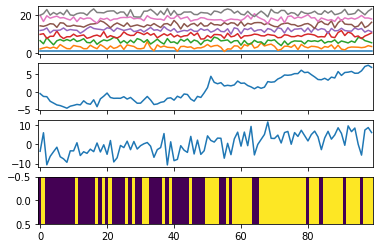

In [ ]:
def plot_session(index, params):
    inputs = all_inputs[index]
    states = all_states[index]
    emissions = all_emissions[index]

    fig, axs = plt.subplots(4, 1, sharex=True)
    axs[0].plot(inputs + 3 * jnp.arange(input_dim))
    axs[1].plot(states)
    axs[2].plot(inputs @ params["w"] + states[:, 0])
    axs[3].imshow(emissions.T, aspect="auto", interpolation="none")

plot_session(0, true_params)

## Approximate the posterior with CMGF

In [ ]:
def compute_posterior(params, inputs, emissions):
    model, model_params = make_model(params)
    posterior = conditional_moments_gaussian_smoother(
        model_params, EKFIntegrals(), emissions, inputs=inputs)
    return posterior


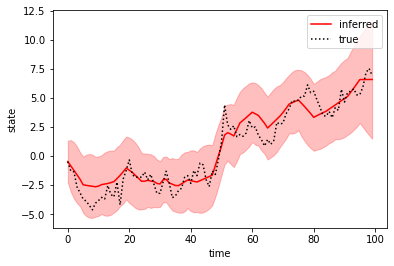

In [ ]:
def plot_posterior(params, index):
    inputs = all_inputs[index]
    states = all_states[index]
    emissions = all_emissions[index]

    posterior = compute_posterior(params, inputs, emissions)
    smoothed_mean = posterior.smoothed_means[:, 0]
    smoothed_std = jnp.sqrt(posterior.smoothed_covariances[:, 0, 0])

    plt.fill_between(jnp.arange(num_timesteps), 
                    smoothed_mean - 2 * smoothed_std,
                    smoothed_mean + 2 * smoothed_std, color='r', alpha=0.25)
    plt.plot(posterior.smoothed_means, color='r', label="inferred")
    plt.plot(states, ':k', label="true")
    plt.xlabel("time")
    plt.ylabel("state")
    plt.legend()

plot_posterior(true_params, 0)

## Optimize the parameters by gradient descent

In [ ]:
def objective(params):
    # compute the marginal log likelihood of all the sessions
    # normalize the output so its O(1)
    # negate since we're minimizing
    posteriors = vmap(partial(compute_posterior, params))(all_inputs, all_emissions)
    return -posteriors.marginal_loglik.mean() / num_timesteps

objective(true_params)

DeviceArray(0.29698452, dtype=float32)

In [ ]:
def run_gradient_descent(objective,
                         params,
                         optimizer=optax.adam(1e-2),
                         optimizer_state=None,
                         num_steps=1000):

    if optimizer_state is None:
        optimizer_state = optimizer.init(params)

    # Minimize the negative expected log joint with gradient descent
    loss_grad_fn = value_and_grad(objective)

    # One step of the algorithm
    def train_step(carry, args):
        params, optimizer_state = carry
        loss, grads = loss_grad_fn(params)
        updates, optimizer_state = optimizer.update(grads, optimizer_state)
        params = optax.apply_updates(params, updates)
        return (params, optimizer_state), loss

    # Run the optimizer
    initial_carry =  (params, optimizer_state)
    (params, optimizer_state), losses = \
        lax.scan(train_step, initial_carry, None, length=num_steps)

    # Return the updated parameters
    return params, optimizer_state, losses


In [ ]:
# Run gradient descent
init_params = initialize_params(jr.PRNGKey(0))
fit_params, _, losses = run_gradient_descent(objective, init_params)

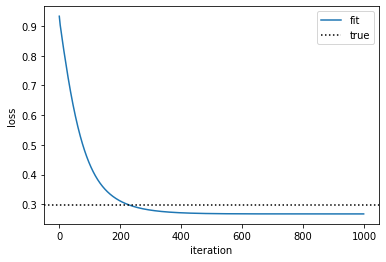

In [ ]:
plt.plot(losses, label="fit")
plt.axhline(objective(true_params), ls=':', color='k', label="true")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()

In [ ]:
# Compare true and inferred params
jnp.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

for key in ["A", "unc_eta", "w"]:
    print(key)
    print("true:", true_params[key])
    print("init:", init_params[key])
    print("fit: ", fit_params[key])
    print()

A
true: [[1.00]]
init: [[0.89]]
fit:  [[1.00]]

unc_eta
true: [0.00]
init: [0.58]
fit:  [-1.13]

w
true: [-0.83 1.78 -1.55 1.72 0.98 -1.56 -2.00 -1.00]
init: [-0.39 -1.47 0.55 2.10 1.12 0.16 -0.54 -0.89]
fit:  [-0.53 1.17 -1.04 1.10 0.61 -1.02 -1.32 -0.67]



Text(0.5, 1.0, 'posterior with fit params')

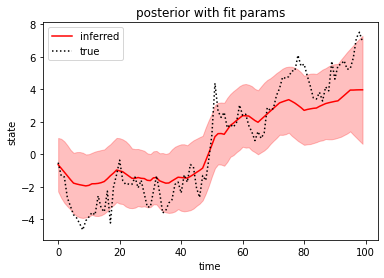

In [ ]:
plot_posterior(fit_params, 0)
plt.title("posterior with fit params")

Text(0.5, 1.0, 'posterior with true params')

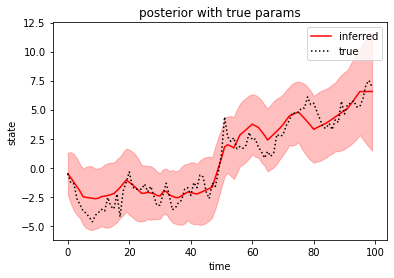

In [ ]:
plot_posterior(true_params, 0)
plt.title("posterior with true params")